# Working with Geospatial Data using Rasterio

In this notebook, we'll explore how to use Rasterio, a powerful library for working with raster data in Python. We will load, process, and visualize a raster dataset, demonstrating basic functionalities such as reading the data, reprojection, and integration with Folium for mapping.


## Import Necessary Libraries

Ensure these are included in your Conda environment.

In [1]:
import rasterio
from rasterio import warp 
from rasterio.plot import show
import folium


## Load Geospatial Raster Data

Here we load a raster file to understand its metadata and visualize its first band.

Raster count: 4
Raster bounds: BoundingBox(left=0.5, bottom=0.5, right=10328.5, top=7760.5)
Coordinate Reference System (CRS): None


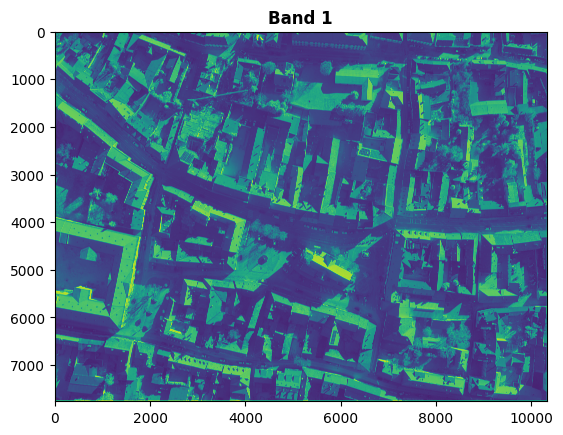

In [2]:
# Path to the raster file
raster_file = 'C:\\Users\HOSS\Desktop\Master\Python\Hainburg_Winter_4_CIR.tif'

# Open the raster file
with rasterio.open(raster_file) as src:
    # Display raster info
    print(f"Raster count: {src.count}")
    print(f"Raster bounds: {src.bounds}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    
    # Show the first band
    show(src.read(1), title="Band 1")


## Raster Data Reprojection and Masking

Reproject the raster to a different coordinate system and mask it using a shapefile.


In [3]:
# Example for reprojection (CRS transformation)
with rasterio.open(raster_file) as src:
    # Calculate the transformation and new dimensions
    transform, width, height = warp.calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and write to the new raster file with the transformed CRS
    with rasterio.open('C:\\Users\HOSS\Desktop\Master\Python\output_transformed.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=warp.Resampling.nearest)


## Interactive Map Visualization Using Folium

Display the processed raster data on an interactive map.


In [1]:
import rasterio
import png

def convert_tiff_to_png(tiff_path, png_path):
    with rasterio.open(tiff_path) as src:
        data = src.read(1)  # Lesen Sie nur die erste Band für Einfachheit
        with open(png_path, 'wb') as f:
            writer = png.Writer(width=src.width, height=src.height, bitdepth=8, greyscale=True)
            # Normieren Sie die Daten auf 0-255 für PNG
            rescaled = (255 * (data - data.min()) / (data.max() - data.min())).astype('uint8')
            writer.write(f, rescaled.tolist())

# Konvertieren Sie die TIFF-Datei in eine PNG-Datei
convert_tiff_to_png('C:\\Users\\HOSS\\Desktop\\Master\\Python\\output_transformed.tif', 'output_transformed.png')


In [3]:
import folium

# Berechnen Sie die Zentrumskoordinaten und Grenzen
with rasterio.open('C:\\Users\\HOSS\\Desktop\\Master\\Python\\output_transformed.tif') as src:
    bounds = src.bounds
    latitude = (bounds.top + bounds.bottom) / 2
    longitude = (bounds.left + bounds.right) / 2

min_lat = bounds.bottom
min_lon = bounds.left
max_lat = bounds.top
max_lon = bounds.right

# Erstellen Sie eine Karte zentriert um die berechneten Koordinaten
map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Laden des PNG-Bildes in die Karte
folium.raster_layers.ImageOverlay(
    image='output_transformed.png',
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    opacity=0.5,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(map)

map
